In [227]:
%matplotlib inline

In [228]:
import matplotlib.pyplot as plt
import numpy as np
import time
import math
from collections import Counter
from tqdm import tqdm

from tiles import *

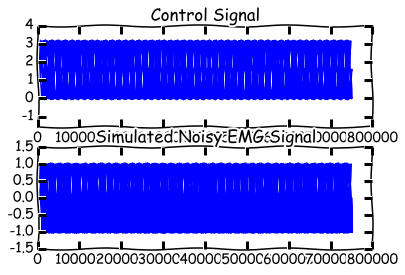

In [229]:
plt.xkcd()  # Yes...

tmax = 750000

t = tmax*np.linspace(0, 1, tmax, endpoint=False)

# Define the target angle
targetElbow = np.zeros(tmax)
for i in range(0, tmax, 4000): 
    targetElbow[i:1000] = 0
    targetElbow[i+1000:i+2000] = math.pi/2
    targetElbow[i+2000:i+3000] = math.pi
    targetElbow[i+3000:i+4000] = math.pi/2

# Two subplots, unpack the axes array immediately
plt.figure(figsize=(40,40))
f, (ax1, ax2) = plt.subplots(2, 1, sharey=False)

ax1.plot(t, targetElbow)
ax1.set_ylim([-math.pi/2, 4])
ax1.set_title('Control Signal')

delay = 0

noise = np.random.normal(0,0.1,tmax)
simEMG = [0] * (tmax+delay)

for i in range(1,tmax):
    if targetElbow[i] == math.pi/2:
        simEMG[i + delay] = -1
    elif targetElbow[i] < math.pi/2:
        simEMG[i + delay] = 0
    elif targetElbow[i] > math.pi/2:
        simEMG[i + delay] = 1
        
simEMGdiff = simEMG[0:tmax] # +noise

ax2.plot(t, simEMGdiff)
ax2.set_ylim(-1.5, 1.5)
ax2.set_title('Simulated Noisy EMG Signal')

In [230]:
# Implement a learning algorithm to try to fit the signal

# store the variables for plitting after learning
jointAngle = np.zeros(tmax)

# Initialize the state array for the trajectory
# Possible feedback from the simulated arm includes the angle
# (in radians) and angular velocity (in radians per second) of
# each joint, and the Cartesian position of the end effector.

# The continuous state space is composed of joint angles 
# and differential EMG signals, for simplicity we will use 
# single joint angle and a single emg differetial signal
s = np.array([0,0])

# Different values for the 2013 paper
# lambdw = 0.3
# lambdv = 0.7

# Standard deviation should cover the possible action set
maxAngVelInt = 1023
stdC = maxAngVelInt

# Initialize the saved variables
reward = np.zeros(tmax)
delta = np.zeros(tmax)
agentMean = np.zeros(tmax)
agentStd = np.zeros(tmax)

# this defines the resolution of the tiling
numTilings = 25
resolutions = np.array([10])
# resolutions = np.array([5,8,12,20])
numFeatures = len(s)

# Initialize the learning parameters
# m is the number of active features in the feature vector
m = numTilings * len(resolutions) + 1
gamma = 0.6 # 0.99
lambd = 0.1 #0.3

alphaV = 0.1/m

# alphaW = 0.01/m

alphaU = 0.01/m #0.005/m
alphaS = 0.01/m #25*alphaU

# Actual length is the concatenation at different resolutions
# and the baseline feature
featVecLength = sum(np.power(resolutions,numFeatures)*numTilings)+1

# Initialize the weight vectors to zero 
# the should be as long as the feature vector x
elV = np.zeros(featVecLength)
elU = np.zeros(featVecLength)
elS = np.zeros(featVecLength)
v = np.zeros(featVecLength)
wU = np.zeros(featVecLength)
wS = np.zeros(featVecLength)

# This function converts the angular velocity from an integer in the range [-1023,1023]
# to an angular velocity in radians per second.
# The no-load speed of the motor is ~60RPM, which is around 6 radians per second
# rad/s = rot(RPM) 2*pi/60
# This should give a good simulation of the true robotic kinematics
def conAngIntToangVel(angInt):
    motorVel = 600
    angVel = motorVel * angInt / maxAngVelInt
    return angVel

def featurize(s):
    
    # TODO: all components in s were normalized to the range [0, 1]
    # according to their minimum and maximum possible values
    # (((OldValue - OldMin) * (NewMax - NewMin)) / (OldMax - OldMin)) + NewMin
    newAngle = (((s[0] - 0) * (1 - 0)) / (math.pi - 0)) + 0
    newEMG = (((s[1] - (-1.5)) * (1 - 0)) / (1.5 - (-1.5))) + 0

    # x is the active tiles in this featurization
    # This featurization should return a single binary feature vector
    # with exactly m features in x(s) active at any time
    # Binary feature vector has a length of 4636426 or
    # sum(np.power(np.array([5,8,12,20]),4)*25)+1
    x = np.zeros(1)
    
    # Single active baseline unit
    x[0] = 1 
    
    # For each resolution the features are needed 
    for res in np.nditer(resolutions):
        
        resVec = np.zeros(np.power(res,numFeatures)*numTilings)
        
        floatArray = np.array([newAngle*res,newEMG*res])
 
        # Get the indexes of the tiles
        tilesOut = tiles(numTilings, res, floatArray) 
        
        # For each tile index flip a feature in the feature vector
        for i in range(len(tilesOut)):
            resVec[tilesOut[i] + (res**2 * i)] = 1
        
        x = np.append(x,resVec)
    
    return x

def getReward(newAngle,timeStep):
    # Define the reward function of the system
    # A positive reward of rt = 1.0 was
    # delivered when θw and θe were both within 0.1 radians of
    # their target angles. A reward of rt = −0.5 was delivered
    # in all other cases, in essence penalizing the learning system
    # when the arm’s posture differed from the target posture.
    targetAngle = targetElbow[timeStep]
    
    absAngleError = np.abs(newAngle-targetAngle)
    
    if absAngleError < 0.1:
        r = 0.1
    else:
        r = -0.5

    return r

def perform(vel,s,timeStep):
    
    # take the action and observe the new state and the reward 
    # new state is defined by the new joint angle
    # which is defined by the old joint angle and the new angular velocity
    # which is applied for that time step and the
    # emg signal at that time index 
    
    # Calculate the new angular state of the joint
    # old angle + angular velocity * time (in this case time = 5ms, the period of action selection)
    # this limits the amount of motion of the joint possible in each action selection
    
    # newAngle = old angle + (angular velocity * time)
    newAngle = s[0] + (vel * 0.005)
    
    # Angle of the joint is limited
    if newAngle < 0:
        newAngle = 0
    elif newAngle > math.pi:
        newAngle = math.pi
    
    # Define the new state space with the new angle and the emg information from the next step
    s = np.array([newAngle,simEMGdiff[timeStep]])
    
    # Get the reward for the new angle
    r = getReward(newAngle,timeStep)
    
    return r,s

# process the training samples that are given
for i in tqdm(range(tmax)):
    
    # Store joint angles for plotting
    jointAngle[i] = s[0]
   
    # Featurize the state
    x = featurize(s)
    
    # Calculate the mean and standard deviation of the action selection
    agentMean[i] = np.dot(wU,x)
    agentStd[i] = max(1,np.exp(np.dot(wS,x) + np.log(stdC)))
    
    # get the action from the normal distribution
    # In cases where more than one action (a is required, 
    # one set of actor parameter vectors (wµ, wσ, eµ, eσ)
    # is maintained for each action (e.g., Tamei and Shibata [17]).

    # angular velocity commands are sent to joints (simulated servos) 
    # as integers in the range [−maxAngVelInt, maxAngVelInt] 
    # normal function takes the mean and standard deviation as inputs
    a = round(np.random.normal(agentMean[i],agentStd[i])) 
    
    # If the action is outside the range, crop to the range
    if a < -maxAngVelInt:
        a = -maxAngVelInt
    elif a > maxAngVelInt:
        a = maxAngVelInt
        
    # Convert the action to an angular velocity
    angVel = conAngIntToangVel(a)
 
    # Take action a and observe the reward, r, and the new state, s
    reward[i],s = perform(angVel,s,i)              
    
    # Featurize the new state
    newX = featurize(s)

    # Calculate the TD Error based on the old state and the new state
    delta[i] = reward[i] + (gamma * np.dot(v,newX)) - np.dot(v,x)
    
    # Critic's eligibility traces 
    elV = (lambd * elV) + x
    
    # Updated eligibility trace from the 2013 paper
    # replacing eligibility traces in the critic used to accelerate learning
    elV = np.minimum(np.ones(featVecLength),elV)
    
    # Critic's parameter vector
    v = v + (alphaV * delta[i] * elV)
    
    # Actors parameters (eligibiliy traces and weight vectors)
    elU = lambd * elU + np.multiply((a - agentMean[i]),x)
    wU = wU + alphaU * delta[i] * elU
    
    elS = lambd * elS + np.multiply(((np.power((a - agentMean[i]),2) / np.power(agentStd[i],2)) - 1),x)
    wS = wS + alphaS * delta[i] * elS

#     print 'Step: ' + str(i)
#     print 'Joint Angle: ' + str(jointAngle[i]) + ' rads'
#     print 'Target Angle: ' + str(targetElbow[i]) + ' rads'
#     print 'Agent Mean: ' + str(agentMean[i])
#     print 'Agent Std: ' + str(agentStd[i])
#     print 'Action: ' + str(conAngIntToangVel(a)) + ' rad/s, move ' + str(conAngIntToangVel(a)*0.005) + ' rads'
#     print 'New Joint Angle: ' + str(s[0]) + ' rads'
#     print 'Reward: ' + str(r)
#     print 'TD Error: ' + str(delta[i])
#     print '\n'

53126.3999995


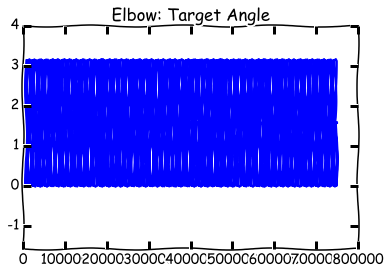

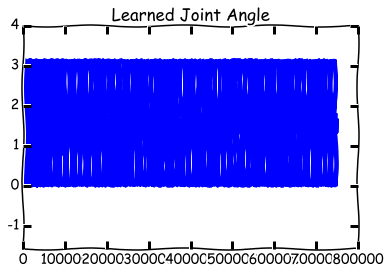

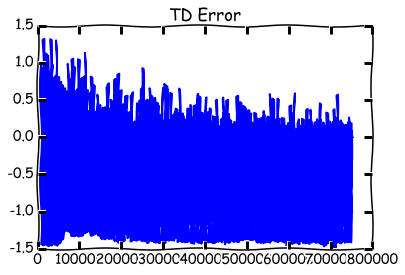

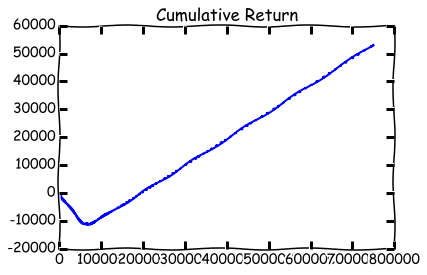

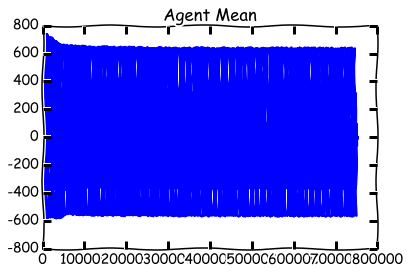

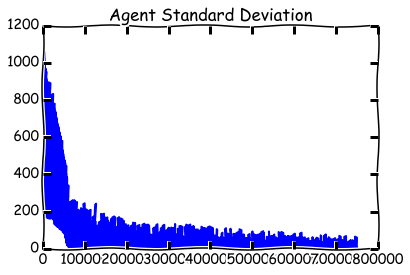

In [231]:
# Visualize the learning    
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(t, targetElbow)
ax1.set_ylim([-math.pi/2, 4])
ax1.set_title('Elbow: Target Angle')

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(t, jointAngle)
ax1.set_ylim([-math.pi/2, 4])
ax1.set_title('Learned Joint Angle')

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(t, delta)
ax1.set_title('TD Error')

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(t, np.cumsum(reward))
ax1.set_title('Cumulative Return')


print np.cumsum(reward)[tmax-1]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(t, agentMean)
ax1.set_title('Agent Mean')

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(t, agentStd)
ax1.set_title('Agent Standard Deviation')

##### 

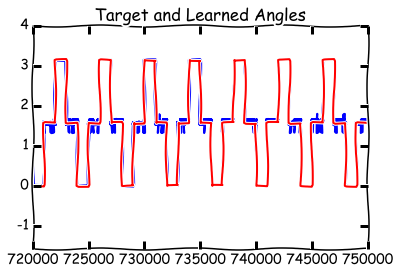

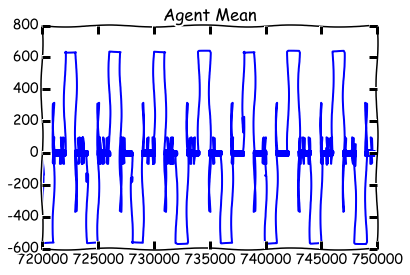

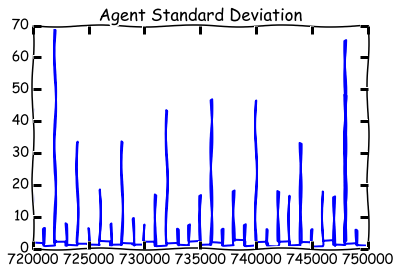

In [240]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(t[720000:750000], jointAngle[720000:750000])
ax1.plot(t[720000:750000], targetElbow[720000:750000])
ax1.set_title('Target and Learned Angles')
ax1.set_ylim([-math.pi/2, 4])

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(t[720000:750000], agentMean[720000:750000])
ax1.set_title('Agent Mean')

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(t[720000:750000], agentStd[720000:750000])
ax1.set_title('Agent Standard Deviation')